# <span style="color:green"> Numerical Simulation Laboratory </span>
## <span style="color:brown"> Python Exercise 12 </span>
## <span style="color:orange"> Keras - Deep & Convolutional Neural Network image recognition </span>

### MNIST con Keras
L'obiettivo di questa esercitazione è di usare delle reti neurali profonde, implementate tramite Keras, per riconoscere le cifre tra $0$ e $9$ scritte a mano. Nel MNIST ci sono $70000$ cifre scritte a mano, ognuna delle quali è in un'immagine quadrata di $28\times 28$ pixel. Ogni pixel può avere 256 gradazioni di grigio, e quindi ogni punto ha un valore tra $0$ e $255$. Quello che andremo a risolvere è quindi un problema di classificazione.

In [2]:
#import os
#os.environ['KMP_DUPLICATE_LIB_OK']='True' #This is needed in my Anaconda+MacOsX installation; leave it commented.
import tensorflow as tf
from tensorflow import keras
import os
import numpy as np
import matplotlib.pyplot as plt
seed=0
np.random.seed(seed) # fix random seed
tf.random.set_seed(seed)

### Step 1: Carica e processa i dati

Keras è in grado di scaricare i dati del MNIST direttamente dal web, quindi l'unica cosa da fare è importare il giusto modulo e caricare i dati, in modo da creare i dati di test e di training. In realtà il MNIST ha dei dati di training pre-definiti.

In [3]:
from keras.datasets import mnist

# input image dimensions
img_rows, img_cols = 28, 28 # number of pixels 
# output
num_classes = 10 # 10 digits

# the data, split between train and test sets
(X_train, Y_train), (X_test, Y_test) = mnist.load_data() #x label, y immagini

print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)

X_train shape: (60000, 28, 28)
Y_train shape: (60000,)


#### Ridimensionare i dati e convertire le etichette per l'uso con l'entropia incrociata categorica

X_train shape: (60000, 784)
X_test shape: (10000, 784)

an example of a data point with label 4


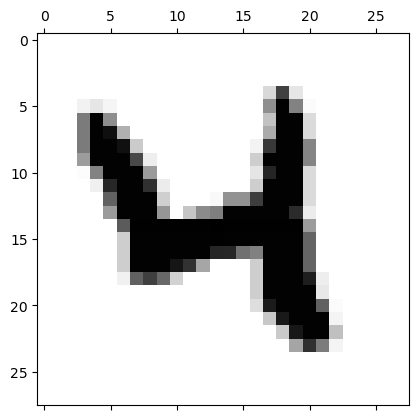

... and with label [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.] after to_categorical

X_train shape: (60000, 784)
Y_train shape: (60000, 10)


In [4]:
# reshape data, it could depend on Keras backend
X_train = X_train.reshape(X_train.shape[0], img_rows*img_cols) #faccio reshape e faccio diventare dati un 28x28
X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print()

# cast to floats
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# rescale data in interval [0,1], stai normalizzando
X_train /= 255
X_test /= 255

# look at an example of data point
print('an example of a data point with label', Y_train[20])
# matshow: display a matrix in a new figure window
plt.matshow(X_train[20,:].reshape(28,28),cmap='binary')
plt.show()

# convert class vectors to binary class matrices, e.g. for use with categorical_crossentropy
Y_train = keras.utils.to_categorical(Y_train, num_classes)
Y_test = keras.utils.to_categorical(Y_test, num_classes)
print('... and with label', Y_train[20], 'after to_categorical')
print()
print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)

### Step 2: Definire il neural net e la sua architettura
Ora possiamo passare alla costruzione della nostra rete neurale profonda. Utilizzeremo la classe Sequential() di Keras per istanziare un modello e aggiungeremo diversi strati profondi uno alla volta utilizzando il metodo add().

Per gli scopi del nostro esempio, ci concentreremo sui soli strati Dense per semplicità. Ogni strato Dense() accetta come primo argomento obbligatorio un numero intero che specifica il numero di neuroni. Il tipo di funzione di attivazione per lo strato è definito utilizzando l'argomento opzionale activation, il cui input è il nome della funzione di attivazione nel formato string. Esempi includono relu, tanh, elu, sigmoid, softmax.

Per far sì che la nostra DNN funzioni correttamente, dobbiamo assicurarci che il numero di neuroni di input e output per ciascuno strato corrisponda. Pertanto, specifichiamo la forma dell'input nel primo strato del modello esplicitamente utilizzando l'argomento opzionale input_shape=(N_features). La costruzione sequenziale del modello consente quindi a Keras di inferire automaticamente le dimensioni corrette di input/output di tutti gli strati nascosti. Di conseguenza, è sufficiente specificare la dimensione dello strato di output softmax in modo che corrisponda al numero di categorie.

In [5]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

def create_DNN():
    # instantiate model
    model = Sequential()
    # add a dense all-to-all relu layer
    model.add(Dense(400,input_shape=(img_rows*img_cols,), activation='relu'))
    # add a dense all-to-all relu layer
    model.add(Dense(100, activation='relu'))
    # apply dropout with rate 0.5
    model.add(Dropout(0.5))
    # soft-max layer
    model.add(Dense(num_classes, activation='softmax')) #la softmax rende il vettore una probabilità
    
    return model

print('Model architecture created successfully!')

Model architecture created successfully!


### Step 3: Scegliere l'ottimizzatore e la funzione costo

Successivamente, scegliamo la loss function secondo cui addestrare la rete neurale profonda. Per i problemi di classificazione, questa è l'entropia incrociata, e dato che i dati di output sono stati convertiti nel formato categorico, scegliamo categorical_crossentropy definito nel modulo losses di Keras. A seconda del problema di interesse, si può scegliere qualsiasi altra loss function adatta. Per ottimizzare i pesi della rete, scegliamo SGD. Questo algoritmo è già disponibile per l'uso nel modulo optimizers di Keras, ma potremmo utilizzare anche un altro ottimizzatore integrato. I parametri per l'ottimizzatore, come lr (learning rate) o momentum, vengono passati utilizzando gli argomenti opzionali corrispondenti della funzione SGD(). Tutti gli argomenti disponibili possono essere trovati nella documentazione online di Keras su https://keras.io/. Mentre la funzione di perdita e l'ottimizzatore sono essenziali per la procedura di addestramento, per testare le prestazioni del modello si può valutare una particolare metrica di performance. Ad esempio, nei compiti categorici si guarda tipicamente l'accuratezza, definita come la percentuale di punti dati classificati correttamente. Per completare la definizione del nostro modello, utilizziamo il metodo compile(), con argomenti opzionali per l'optimizer, la loss e la metrica di validazione come segue:

In [6]:
from keras.optimizers import SGD, Adam, RMSprop, Adagrad, Adadelta, Adam, Adamax, Nadam

def compile_model():
    # create the model
    model=create_DNN()
    # compile the model
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=SGD(),
                  metrics=['acc'])
    return model

print('Model compiled successfully and ready to be trained.')

Model compiled successfully and ready to be trained.


### Step 4: Addestrare il modello
Alleniamo la nostra DNN in minibatches, cioè dividendo l'intero set di dati in set più piccoli.

Mescolare i dati di addestramento durante il training migliora la stabilità del modello. Pertanto, addestriamo per un certo numero di epoche di training. Ogni epoca corrisponde all'uso di tutti i dati di training divisi in minibatches.

Addestrare la DNN è semplice usando il metodo fit() della classe Sequential. I primi due argomenti obbligatori sono i dati di input e output di training. Come argomenti opzionali, specifichiamo la dimensione del mini-batch (batch_size), il numero di epoche di training (epochs), e i dati di validation_data o test. Per monitorare la procedura di training per ogni epoca, impostiamo verbose=True.

In [8]:
# training parameters
batch_size = 32
epochs = 50 #mettere almeno 50 epoche, è più complesso, divido in gruppi da 32 immagini e caloclo gradiente su quelle, cosi ho dati numerosi e prendi direzioni buone e non mi blocco su minimi locali

# create the deep neural net
model_DNN = compile_model()

# train DNN and store training info in history
history = model_DNN.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, Y_test))

Epoch 1/50
1875/1875 [==============================] - 21s 11ms/step - loss: 0.7444 - acc: 0.7837 - val_loss: 0.3148 - val_acc: 0.9157
Epoch 2/50
1875/1875 [==============================] - 17s 9ms/step - loss: 0.3876 - acc: 0.8902 - val_loss: 0.2417 - val_acc: 0.9324
Epoch 3/50
1875/1875 [==============================] - 17s 9ms/step - loss: 0.3149 - acc: 0.9120 - val_loss: 0.2031 - val_acc: 0.9416
Epoch 4/50
1875/1875 [==============================] - 22s 12ms/step - loss: 0.2700 - acc: 0.9242 - val_loss: 0.1771 - val_acc: 0.9475
Epoch 5/50
1875/1875 [==============================] - 14s 8ms/step - loss: 0.2386 - acc: 0.9336 - val_loss: 0.1608 - val_acc: 0.9524
Epoch 6/50
1875/1875 [==============================] - 19s 10ms/step - loss: 0.2160 - acc: 0.9397 - val_loss: 0.1441 - val_acc: 0.9562
Epoch 7/50
1875/1875 [==============================] - 16s 9ms/step - loss: 0.1909 - acc: 0.9458 - val_loss: 0.1305 - val_acc: 0.9597
Epoch 8/50
1875/1875 [==============================

### Step 5: Valutazione e performance del modello usando dati di test mai visti
Ora valutiamo il modello e guardiamo la perdita nei dati di test, e la loro accuratezza usando il metodo evaluate()

313/313 [==============================] - 3s 8ms/step - loss: 0.0618 - acc: 0.9815

Test loss: 0.06178898364305496
Test accuracy: 0.9815000295639038


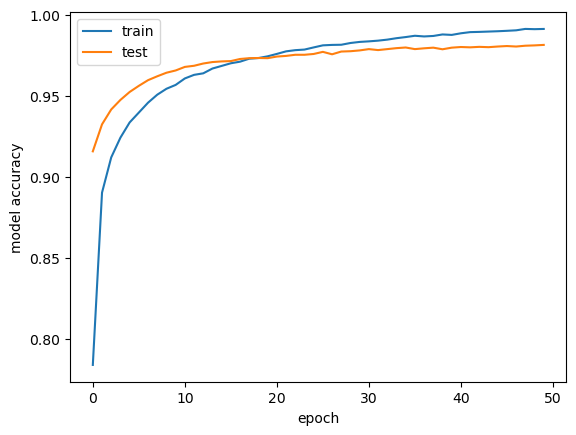

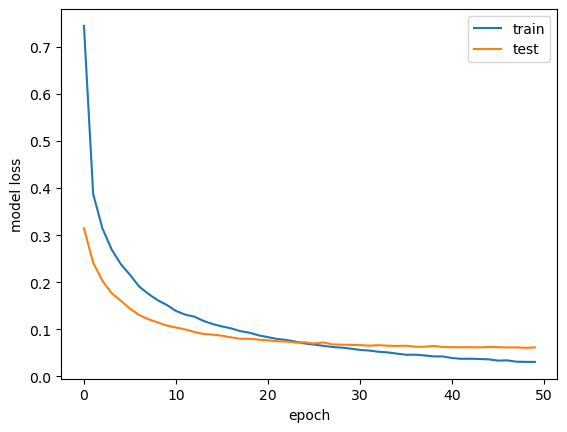

In [9]:
# evaluate model
score = model_DNN.evaluate(X_test, Y_test, verbose=1)

# print performance
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# look into training history

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('model accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

313/313 [==============================] - 1s 4ms/step


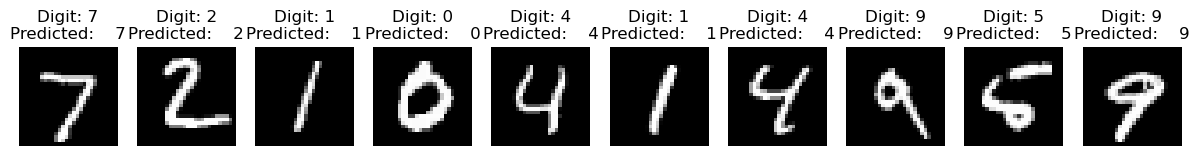

In [10]:
#X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)
predictions = model_DNN.predict(X_test)

X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols,1)

plt.figure(figsize=(15, 15)) 
for i in range(10):    
    ax = plt.subplot(2, 10, i + 1)    
    plt.imshow(X_test[i, :, :, 0], cmap='gray') 
    plt.title("Digit: {}\nPredicted:    {}".format(np.argmax(Y_test[i]), np.argmax(predictions[i])))    
    plt.axis('off') 
plt.show()

### Creare reti neurali convoluzionali con Keras
Fino ad ora abbiamo considerato ogni campione di dati MNIST come un vettore 1D lungo $(28 \times 28,)$. D'altra parte, sappiamo che in ogni cifra scritta a mano ci sono correlazioni spaziali locali tra i pixel, ma anche invarianza traslazionale, di cui vorremmo approfittare per migliorare l'accuratezza del nostro modello di classificazione. A tal fine, abbiamo bisogno di ridimensionare i dati di input di addestramento e test nel seguente modo:


In [11]:
# you will need the following for Convolutional Neural Networks
from keras.layers import Flatten, Conv2D, MaxPooling2D

# reshape data, depending on Keras backend
if keras.backend.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
    
print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)
print()
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (60000, 28, 28, 1)
Y_train shape: (60000, 10)

60000 train samples
10000 test samples


### Exercise 12.2
In questo esercizio dobbiamo cambiare l'architettura della rete neurale profonda usando layer convoluzionali, come `Conv2D`, `MaxPooling2D`, `Dropout`,`Flatten`,`Dense` e `soft-max` alla fine. Gli step $2$ e $3$ sono stati uniti nel 'create_CNN()'.

Epoch 1/50
1875/1875 [==============================] - 105s 56ms/step - loss: 0.9050 - acc: 0.6981 - val_loss: 0.1922 - val_acc: 0.9436
Epoch 2/50
1875/1875 [==============================] - 115s 61ms/step - loss: 0.3128 - acc: 0.9052 - val_loss: 0.1203 - val_acc: 0.9635
Epoch 3/50
1875/1875 [==============================] - 117s 62ms/step - loss: 0.2288 - acc: 0.9296 - val_loss: 0.0913 - val_acc: 0.9706
Epoch 4/50
1875/1875 [==============================] - 117s 62ms/step - loss: 0.1938 - acc: 0.9422 - val_loss: 0.0739 - val_acc: 0.9756
Epoch 5/50
1875/1875 [==============================] - 128s 68ms/step - loss: 0.1658 - acc: 0.9505 - val_loss: 0.0670 - val_acc: 0.9790
Epoch 6/50
1875/1875 [==============================] - 121s 64ms/step - loss: 0.1496 - acc: 0.9543 - val_loss: 0.0565 - val_acc: 0.9820
Epoch 7/50
1875/1875 [==============================] - 126s 67ms/step - loss: 0.1385 - acc: 0.9589 - val_loss: 0.0533 - val_acc: 0.9816
Epoch 8/50
1875/1875 [===================

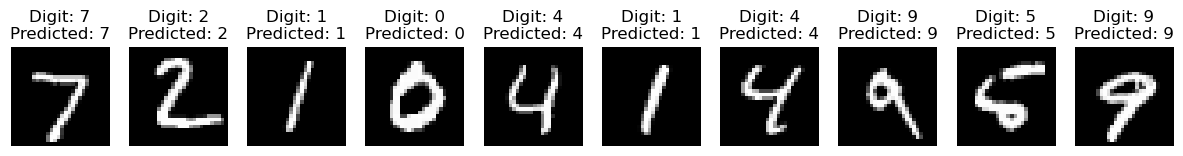

In [12]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
import keras

def create_CNN(input_shape, num_classes):
    # Instantiate model
    model = Sequential()

    # Add first convolutional layer with 10 filters (dimensionality of output space)
    model.add(Conv2D(10, kernel_size=(5, 5), activation='relu', input_shape=input_shape))

    # Add max pooling layer
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Add second convolutional layer with 20 filters
    model.add(Conv2D(20, kernel_size=(5, 5), activation='relu'))

    # Add another max pooling layer
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Add dropout layer
    model.add(Dropout(0.25))

    # Flatten the network
    model.add(Flatten())

    # Add a fully connected layer
    model.add(Dense(128, activation='relu'))

    # Add another dropout layer
    model.add(Dropout(0.5))

    # Add softmax layer
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer='SGD',
                  metrics=['acc'])

    return model

# Training parameters
batch_size = 32
epochs = 50  # Inserire un numero adeguato di epoche

# Assumiamo che `input_shape`, `num_classes`, `X_train`, `Y_train`, `X_test` e `Y_test` siano già definiti
input_shape = (28, 28, 1)  # Esempio di input shape per immagini 28x28 in scala di grigi
num_classes = 10  # Numero di classi nel dataset

# Create the deep conv net
model_CNN = create_CNN(input_shape, num_classes)

# Train CNN
model_CNN.fit(X_train, Y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              validation_data=(X_test, Y_test))

# Evaluate model
score = model_CNN.evaluate(X_test, Y_test, verbose=1)

# Print performance
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# Predictions
predictions = model_CNN.predict(X_test)

# Visualize some predictions
plt.figure(figsize=(15, 15))
for i in range(10):
    ax = plt.subplot(2, 10, i + 1)
    plt.imshow(X_test[i, :, :, 0], cmap='gray')
    plt.title("Digit: {}\nPredicted: {}".format(np.argmax(Y_test[i]), np.argmax(predictions[i])))
    plt.axis('off')
plt.show()


### Exercise 12.3

In questo esercizio scriveremo le $10$ cifre a mano tramite l'applicazione gimp, e poi le importeremo e vedremo se la rete neurale è in grado di riconoscerle.

Image size: 28x28
Image size: 28x28
Image size: 28x28
Image size: 28x28
Image size: 28x28
Image size: 28x28
Image size: 28x28
Image size: 28x28
Image size: 28x28
Image size: 28x28
Data shape (reshaped for prediction): (10, 28, 28, 1)
1/1 [==============================] - 0s 18ms/step


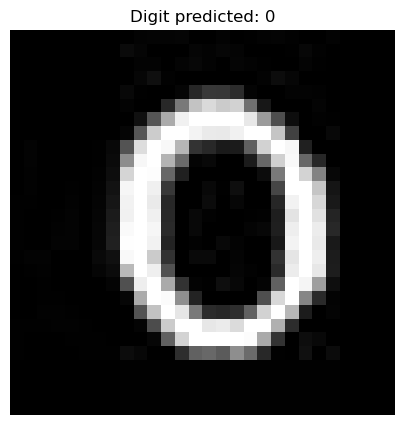

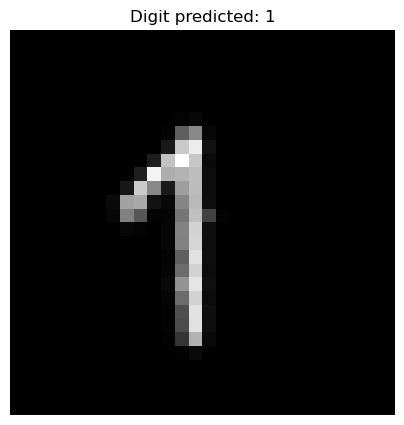

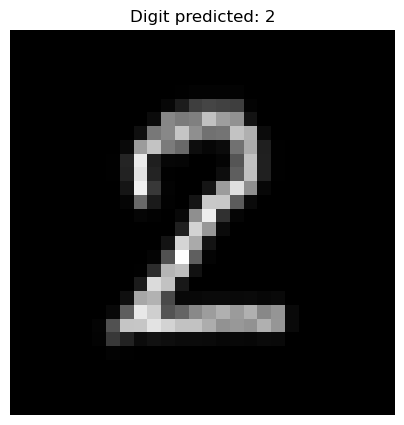

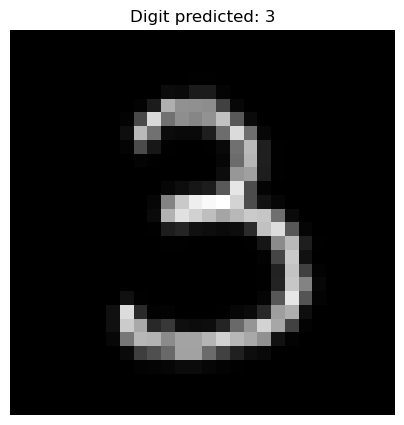

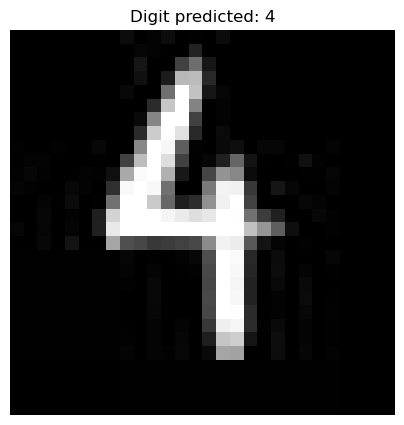

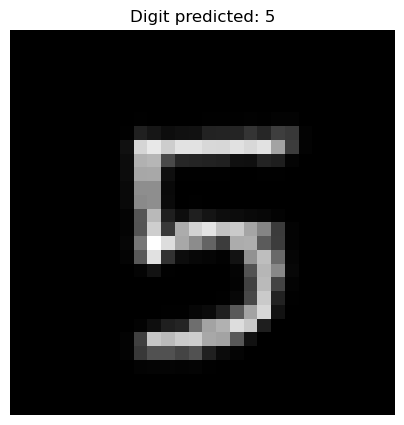

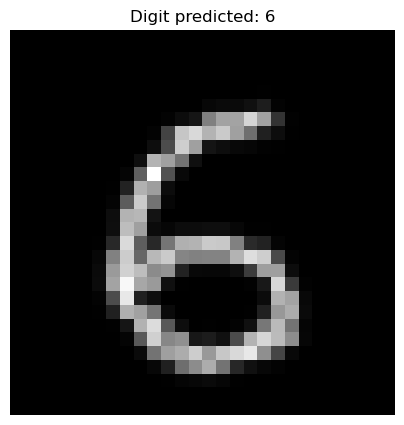

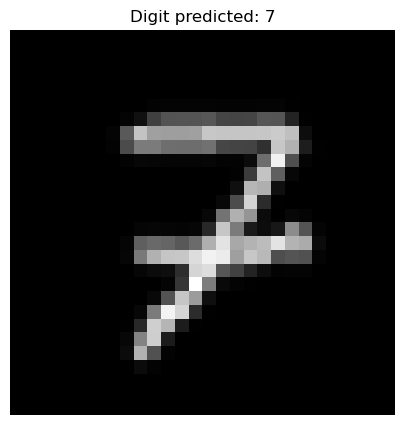

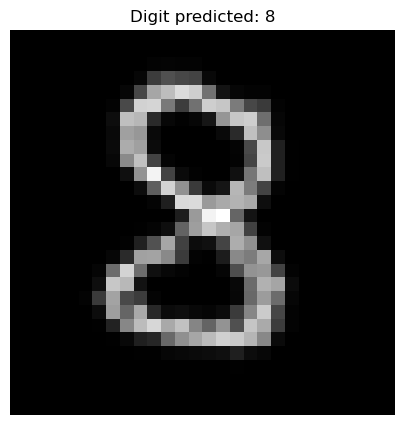

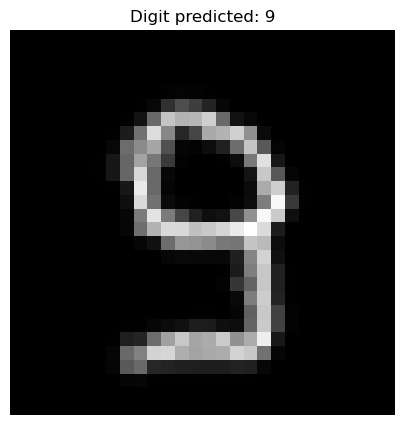

In [22]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Elenco dei percorsi delle immagini
image_filenames = [
    "/home/eleonora/Desktop/Simulazione numerica/lezione 12/numeri/0.png",
    "/home/eleonora/Desktop/Simulazione numerica/lezione 12/numeri/1.png",
    "/home/eleonora/Desktop/Simulazione numerica/lezione 12/numeri/2.png",
    "/home/eleonora/Desktop/Simulazione numerica/lezione 12/numeri/3.png",
    "/home/eleonora/Desktop/Simulazione numerica/lezione 12/numeri/4.png",
    "/home/eleonora/Desktop/Simulazione numerica/lezione 12/numeri/5.png",
    "/home/eleonora/Desktop/Simulazione numerica/lezione 12/numeri/6.png",
    "/home/eleonora/Desktop/Simulazione numerica/lezione 12/numeri/7.png",
    "/home/eleonora/Desktop/Simulazione numerica/lezione 12/numeri/8.png",
    "/home/eleonora/Desktop/Simulazione numerica/lezione 12/numeri/9.png"
]

# Lista per salvare i dati delle immagini
data_list = []

for digit_filename in image_filenames:
    # Carica l'immagine e converti in scala di grigi
    digit_in = Image.open(digit_filename).convert('L')

    # Ottieni le dimensioni dell'immagine (presumiamo che tutte le immagini abbiano le stesse dimensioni)
    xdim, ydim = digit_in.size
    print("Image size: "+str(xdim)+"x"+str(ydim))

    # Carica i pixel dell'immagine e crea un array numpy
    pix = digit_in.load()
    data = np.zeros((xdim, ydim))
    for j in range(ydim):
        for i in range(xdim):
            data[i, j] = pix[i, j]

    # Normalizza i dati
    data /= 255

    # Aggiungi l'immagine alla lista
    data_list.append(data)

# Converti la lista in un array numpy e ridimensiona i dati per la previsione
data_array = np.array(data_list).reshape(len(data_list), xdim, ydim, 1)
print("Data shape (reshaped for prediction):", data_array.shape)

# Esegui la previsione
pred_0 = model_CNN.predict(data_array)

# Visualizza le immagini e le previsioni
for i in range(len(data_list)):
    data = data_list[i].reshape(xdim, ydim)

    plt.figure(figsize=(5, 5))
    plt.imshow(data, cmap='gray')
    plt.title("Digit predicted: {}".format(np.argmax(pred_0[i])))
    plt.axis('off')
    plt.show()
  
